In [8]:
#Import packages
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms.time_evolvers.trotterization import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit import Aer



import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


### 1) Dynamic evolution a single spin-1/2 particle

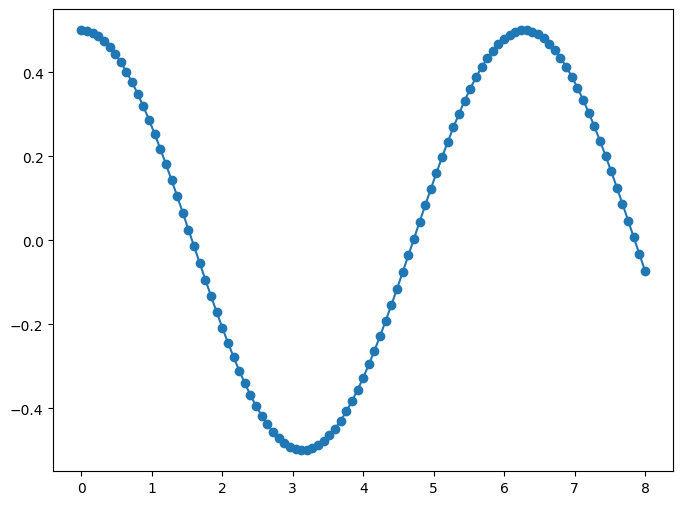

In [10]:
#Create the initial state |0>
qreg = QuantumRegister(size = 1)
qcir = QuantumCircuit(qreg)

#Define the hamiltonian
omega = 0.5
hamiltonian = SparsePauliOp(data = "X", coeffs = -omega)

#Define the observable and the estimator
obs = SparsePauliOp(data = "Z", coeffs = 0.5)
estimator = Estimator()

#Define the evolution problem
time = 8.0
initial_state = qcir
problem = TimeEvolutionProblem(hamiltonian,time,initial_state,aux_operators=[obs])

#Evolve the system
num_timesteps = 100
evolution = TrotterQRTE(estimator=estimator, num_timesteps=num_timesteps).evolve(problem)

#Get the observable values
obs_values = np.array(evolution.observables)[:,:,0][:,0]

#Visualize the time evolution of the observable
x_times = np.linspace(0,time,num=num_timesteps+1)
fig = plt.figure(figsize=(8,6))
plt.plot(x_times,obs_values,'o-')

### 2) Dynamic evolution a single spin-1/2 particle with spontaneous collapse

In [36]:
#Define the collapse times
def _collapse_times(time, lam):
    """
    Generate an array of value with poisson distribution that represent the collapses.

    Parameter:
        - time(int): Max time of the experiment, the last collapse must to be before the max time
        - lam(float): Mean value of the poisson distribution that represents the rate of appearence of the collapses

    Return:
        - collapse_array(np.array): Array of sampled element from the poisson distribution 
    
    """
    t_run = 0 # count at which time we are when we sample a new value from the poisson distribution
    collapse_array = []
    while t_run <= time:
        t = np.random.poisson(lam,size=1)
        if t == 0: # beacuse the collapse doesn't happen at the same time of the previous one
            continue
        t_run += t
        if t_run <= time:
            collapse_array.append(t)
    
    return np.array(collapse_array)[:,0]

def t_coll(collapse_times):
    """
    This function calculate the exact time at which the collapses happened. This values are used in the plots

    Parameter:
        - collapse_time(np.array): Array of sampled element from the poisson distribution 

    Return:
        - t_collapses(list): Time series of the collapses
    """
    t_collapses = []
    for i in range(len(collapse_times)):
        if i == 0:
            t_collapses.append(collapse_times[0])
        else:
            t_collapses.append(t_collapses[-1] + collapse_times[i])
    return t_collapses


#Define the dynamic

def QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs):
    """
    Apply the trotterization to obtain the resulting state and the mean value of the observable
    
    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - t_col(float): Total time of evolution
        - initial state(QuantumCircuit): The quantum state to be evolved
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - evolution(qiskit object): object that represent the result of the evolution. It must to be used then to extract the circuit after the evolution
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state

    """
    problem = TimeEvolutionProblem(hamiltonian, t_col, initial_state, aux_operators = [obs])
    evolution = TrotterQRTE(estimator = estimator, num_timesteps = n_timesteps).evolve(problem)
    obs_values = np.array(evolution.observables)[:,:,0][:,0]

    return evolution, obs_values


def dynamic(hamiltonian, initial_state, t_col, n_timesteps, obs):
    """
    Evaluate the dynamic until the time of collapse, then evaluate the collapse generating a random number between 0 and 1 and compare with the prob of the stato to be in |0>.

    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - t_col(float): Total time of evolution
        - n_timesteps(int): he number of time-steps the full evolution time is devided into 
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    
    Return:
        - collapse(int): where the state is collapsed
        - obs_values(np.array): Array of mean values of the operator that is evaluated with the evolved initial_state
    """

    evolution, obs_values = QRTE_evolution(hamiltonian, t_col, initial_state, n_timesteps, obs)
    state_pre = evolution.evolved_state  # extract the circuit from the ouput of the QRTE_evolution  

    #Get the state before the collapse as a vector
    backend = Aer.get_backend("statevector_simulator")
    state = execute(state_pre, backend).result().get_statevector(state_pre)

    #Collapse
    x = np.random.uniform(0,1) 
    if x <= np.abs(state[0])**2: # compare the generated number with the prob of the state to be in |0>
        return 0, obs_values
    else:
        return 1, obs_values

    
def experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, obs):
    """
    Apply the dynamics for the whole experiment until the end of the time of the experiment and store the values of obs_values, 
    the number of collpases in |0>, |1> and the time series of collapses.

    Parameter:
        - hamiltonian(BaseOperator | PauliSumOp): The Hamiltonian under which to evolve the system.
        - initial state(QuantumCircuit): The quantum state to be evolved
        - time(int): Total time of the experiment
        - num_timesteps(int): Number of steps in which is divide the whole experiment
        - collapse_times(np.array, dtype:int): Array of the values of the poisson samples that represent the collapses
        - obs(ListOrDict[BaseOperator | PauliSumOp] | None): Optional list of auxiliary operators to be evaluated with the evolved initial_state and their expectation values returned.

    Return:
        - all_obs_values(list_float): All the values of the mean value of the observable operator
        - counter_0(int): Count how many time collapse in |0>
        - counter_1(int): Count how many time collapse in |1>
        - collapse_values(list_float): list of mean values of the operator at the collapses
    """
    # counter for counting how many times the collapses are in |0> and |1>
    counter_0 = 0 
    counter_1 = 0

    # list to append the mean values of the observable and where there are the collapses
    all_obs_values = []
    collapse_values = []

    collapse_timesteps = collapse_times*int(num_timesteps/time)

    # do the dynamics for each interval between two collapses
    for i in tqdm(range(len(collapse_times))):
        spin_state, obs_values = dynamic(hamiltonian, initial_state, collapse_times[i], collapse_timesteps[i], obs)

        # evaluate the resulting state after the collapse
        if spin_state == 0:
            counter_0 += 1
            initial_state = QuantumCircuit(1) 
            collapse_values.append(0.5)
        else:
            counter_1 += 1
            initial_state = QuantumCircuit(1)
            initial_state.x(0)
            initial_state = initial_state
            collapse_values.append(-0.5)

        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])

    # evalute if the last collapse coincidate with the end of the experiment. If this is false a last dynamic is calculated until the end of the time of the experiment  
    if np.sum(collapse_times) != time:
        time_fin = time - np.sum(collapse_times)
        timesteps_fin = num_timesteps - np.sum(collapse_timesteps)
        evolution_trash, obs_values = QRTE_evolution(hamiltonian, time_fin, initial_state, timesteps_fin, obs)
        for j in range(len(obs_values)):
            all_obs_values.append(obs_values[j])
    
    return all_obs_values, counter_0, counter_1, collapse_values


def visualization(all_obs_values, time, num_timesteps, collapse_values, t_collapses, collapse_times):
    """
    Make the plot of the obs values respect to the time of the experiment
    Parameter: 
        - all_obs_values(list_float): All the values of the mean value of the observable operator
        - time(int): Total time of the experiment
        - num_timesteps(int): Number of steps in which is divide the whole experiment
        - collapse_values(list_float): list of mean values of the operator at the collapses  
        - t_collapses(): Time series of the collapses
        - collapse_times():

    Return:
        - The plot
    """
    
    x_times = np.linspace(0,time,num=num_timesteps+len(collapse_times)+1)
    fig = plt.figure(figsize=(12,6))
    plt.plot(x_times,all_obs_values,'-', alpha = 0.5)
    plt.plot(t_collapses, collapse_values, '.', c = 'r')
    plt.title('Collapse for one particle spin 1/2')
    plt.xlabel('Time')
    plt.ylabel('Mean value of Sigma z')
    plt.grid()
    plt.show()


In [31]:
#Define some variables
time = 1000
num_timesteps = 10000


#Define the hamiltonian
omega = 0.01
hamiltonian = SparsePauliOp(data = "X", coeffs = -omega)


#Define the observable and the estimator
obs = SparsePauliOp(data = "Z", coeffs = 0.5)
estimator = Estimator()


# Define the initial state
initial_state = QuantumCircuit(1) # intialize in |0>


# generate the poisson samples
#np.random.seed() # fix a seed
lam = 10 #lambda for the poisson distribution

collapse_times = _collapse_times(time,lam) 
t_collapse = t_coll(collapse_times) 

#print("collapse_times:", collapse_times)
#print("collapse_timesteps:", collapse_times*int(num_timesteps/time))
#print("t_collapses:", t_collapse)

In [32]:
# Do the experiment
y, counter_0, counter_1, collapse_values = experiment(hamiltonian, initial_state, time, num_timesteps, collapse_times, obs)

print("Collapse in |0>: ", counter_0)
print("Collapse in |1>: ", counter_1)


100%|██████████| 103/103 [00:38<00:00,  2.67it/s]


Collapse in |0>:  82
Collapse in |1>:  21


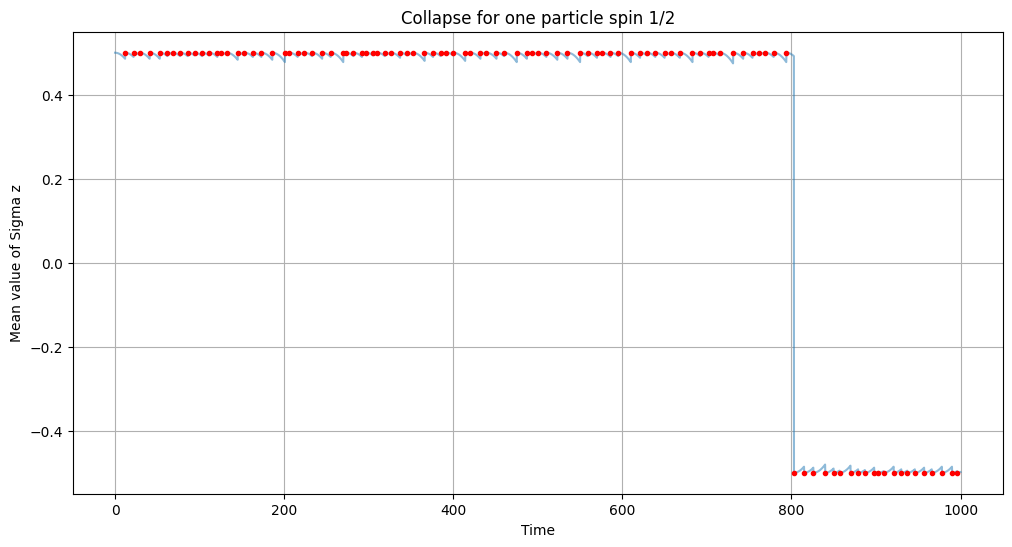

In [37]:
# visualize the plot
visualization(y, time, num_timesteps, collapse_values, t_collapse, collapse_times)